In [9]:
# Update packages

%pip install -U pip wheel setuptools
%pip install -U gensim
%pip install -U matplotlib
%pip install -U nltk
%pip install -U numpy
%pip install -U pandas
%pip install -U sklearn
%pip install -U umap-learn


  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.6.0
    Uninstalling setuptools-65.6.0:
      Successfully uninstalled setuptools-65.6.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 6.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.1
    Uninstalling pandas-1.5.1:
      Successfully uninstalled pandas-1.5.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Cluster Documents

Clustering documents in three main steps:

1. Cleaning and tokenizing data (lowercasing text, removing non-alphanumeric characters, or stemming words).
1. Generating vector representations of the documents mapping words into numerical vectors and aggregate them. Usually done via word-embedding.
1. Applying a clustering algorithm on the document vectors (K-means, DBSCAN, or Hierarchical Clustering).

In [10]:
try:
    from google.colab import drive
    drive.mount('drive')
except ImportError:
    pass

In [ ]:
import os
import random
import re
import string

import pprint

import numpy as np
import pandas as pd

from gensim.models import Word2Vec
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import umap

SEED = 42
random.seed(42)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

pp = pprint.PrettyPrinter(indent=4)

In [54]:
# df = pd.read_csv('../data/posts.csv')
df = pd.read_csv('../data/posts_cleaned.csv')

tokenized_docs = df['tokens'].tolist()

In [56]:
from numpy.lib.function_base import vectorize

VECTOR_SIZE=300

model = Word2Vec(
    sentences=tokenized_docs, 
    vector_size=VECTOR_SIZE, 
    workers=os.cpu_count(),
    seed=SEED
)

In [57]:
# for kw in ['musk', 'obama', 'trump', 'putin', 'zelensky', 'macron']:
# for kw in ['covid', 'vax', 'novax', 'greenpass', 'trump', 'macron', 'mattarella', 'draghi', 'vaccino', 'putin', 'ucraina']:
for kw in ['covid', 'vax', 'novax', 'greenpass', 'trump', 'macron', 'mattarell', 'drag', 'vaccin', 'putin', 'ucrain']:
    try:
        most_similar_words = model.wv.most_similar(kw, topn=5)
    except KeyError:
        most_similar_words = []
    print(kw, [sw[0] for sw in most_similar_words])


covid ['omicron', 'coronavirus', 'astrazenec', 'biontec', 'modern']
vax []
novax ['quartad', 'febbrai', 'speranz', 'siler', 'terzad']
greenpass ['speranz', 'drag', 'over', 'febbrai', 'novax']
trump ['turn', 'sogn', 'diabol', 'destr', 'attor']
macron ['stipul', 'solidariet', 'ruol', 'obsolesct', 'famiger']
mattarell ['siler', 'locatell', 'sanrem', 'ucrain', 'quirinal']
drag ['speranz', 'greenpass', 'ital', 'siler', 'over']
vaccin ['protegg', 'immunizz', 'nonost', 'ammal', 'guar']
putin ['bruxelles', 'russ', 'bravissim', 'ukrain', 'sottomess']
ucrain ['salvin', 'mattarell', 'taleban', 'capezzon', 'locatell']


In [58]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    # the model might not know about a new word
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_docs = vectorize(tokenized_docs, model=model)


For n_clusters = 5
Silhouette coefficient: 0.1463
Inertia: 16463.094791754942
New best found! 0.1463 (5)

For n_clusters = 6
Silhouette coefficient: 0.1469
Inertia: 15723.364100134308
New best found! 0.1469 (6)

For n_clusters = 7
Silhouette coefficient: 0.1288
Inertia: 14934.927617928015
Patience: 1 / 10 | Current best: 0.1469 (6)

For n_clusters = 8
Silhouette coefficient: 0.1324
Inertia: 14161.56838133033
Patience: 2 / 10 | Current best: 0.1469 (6)

For n_clusters = 9
Silhouette coefficient: 0.1217
Inertia: 13586.583943244716
Patience: 3 / 10 | Current best: 0.1469 (6)

For n_clusters = 10
Silhouette coefficient: 0.1097
Inertia: 13404.062324214256
Patience: 4 / 10 | Current best: 0.1469 (6)

For n_clusters = 11
Silhouette coefficient: 0.1164
Inertia: 12750.397133642027
Patience: 5 / 10 | Current best: 0.1469 (6)

For n_clusters = 12
Silhouette coefficient: 0.1249
Inertia: 12063.90074349524
Patience: 6 / 10 | Current best: 0.1469 (6)

For n_clusters = 13
Silhouette coefficient: 0.101

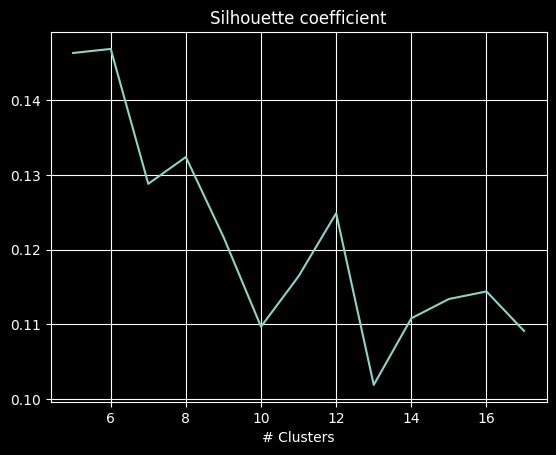

In [59]:
def mbkmeans_clusters(X, k, mb, print_silhouette_values=False, curr_best=None):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    s_score = silhouette_score(X, km.labels_)

    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {s_score:0.4f}")
    print(f"Inertia: {km.inertia_}")
    
    s_values = []
    if curr_best is not None and curr_best < s_score:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            s_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        s_values = sorted(
            s_values, key=lambda tup: tup[2], reverse=True
        )
        if print_silhouette_values:
            print(f"Silhouette values:")
            for s in s_values:
                print(
                    f"\tCluster {s[0]}: Size:{s[1]} - Avg:{s[2]:.2f} - Min:{s[3]:.2f} - Max: {s[4]:.2f}"
                )

    return km, km.labels_, s_score, s_values


# Search for the best k value for clustering
min_k_cluster_size = 5
max_k_cluster_size = 50
max_patience = 10
mini_batch_size = 256*os.cpu_count()

k = None
best_k = None
best_s_coeff = -1
best_s_values = []
best_clustering = None
best_cluster_labels = None
patience = 0
verbose = False
history = []


for k in range(min_k_cluster_size, max_k_cluster_size+1):
    clustering, cluster_labels, s_coeff, s_values = mbkmeans_clusters(
        X=vectorized_docs,
        k=k,
        mb=mini_batch_size,
        print_silhouette_values=verbose,
        curr_best=best_s_coeff
    )
    history.append((k, s_coeff))

    if s_coeff > best_s_coeff:
        best_k = k
        best_clustering = clustering
        best_cluster_labels = cluster_labels
        best_s_coeff = s_coeff
        best_s_values = s_values
        patience = 0
        print("New best found!", f'{best_s_coeff:0.4f}', f'({best_k})')
    else:
        if patience >= max_patience:
            k = best_k
            clustering = best_clustering
            cluster_labels = best_cluster_labels
            s_coeff = best_s_coeff
            s_values = best_s_values
            break
        patience += 1
        print("Patience:", patience, '/', max_patience, "|", "Current best:", f'{best_s_coeff:0.4f}', f'({best_k})')
    print()

plt.plot(
    [x for x, y in history],
    [y for x, y in history],
)
plt.title('Silhouette coefficient')
plt.xlabel('# Clusters')
plt.grid(True)
plt.show()

In [60]:
print("Clusters:", k)
print("Silhoutte coeff:", s_coeff)
print("Silhoutte values:")
for s in s_values:
    print(
        f"\tCluster {s[0]}:\tSize:{s[1]} - Avg:{s[2]:.2f} - Min:{s[3]:.2f} - Max: {s[4]:.2f}"
    )
print()

print("Most representative terms per cluster (based on centroids):")
for i, *_ in s_values:
    tokens_per_cluster = []
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster.append(t[0])
    tokens_per_cluster = ', '.join(tokens_per_cluster)
    print(f"\tCluster {i}:\t{tokens_per_cluster}")

Clusters: 6
Silhoutte coeff: 0.14687753899772038
Silhoutte values:
	Cluster 2:	Size:6384 - Avg:0.26 - Min:0.03 - Max: 0.46
	Cluster 0:	Size:608 - Avg:0.19 - Min:-0.04 - Max: 0.40
	Cluster 3:	Size:3567 - Avg:0.12 - Min:-0.09 - Max: 0.35
	Cluster 1:	Size:3753 - Avg:0.08 - Min:-0.16 - Max: 0.34
	Cluster 5:	Size:1933 - Avg:0.04 - Min:-0.26 - Max: 0.33
	Cluster 4:	Size:1928 - Avg:0.02 - Min:-0.23 - Max: 0.27

Most representative terms per cluster (based on centroids):
	Cluster 2:	porcher, addirittur, plag, scherz, maledett
	Cluster 0:	emiliaromagn, sanrem, quartad, quart, quirinal
	Cluster 3:	neanc, benissim, tranquill, incazz, assolut
	Cluster 1:	allatt, muoi, darann, soffr, malissim
	Cluster 5:	generalizz, diviet, introdurr, richied, adesion
	Cluster 4:	boom, nonost, fasc, dopp, immunodepress


In [61]:
def inspect_cluster(c_id, clustering, docs, vectorized_docs, num=5):
    most_representative_docs = np.argsort(
        np.linalg.norm(vectorized_docs - clustering.cluster_centers_[c_id], axis=1)
    )
    print("Cluster", c_id, "#"*80)
    for i, d in enumerate(most_representative_docs[:num]):
        print(f'({i+1})')
        print(docs[d])
        print()
    print()

for i, *_ in s_values[:3]:
    inspect_cluster(i, clustering, docs, vectorized_docs, num=3)

Cluster 2 ################################################################################
(1)
Non ho parole. Se pure i medici appecorati non la capiscono penso non vi sia speranza alcuna. Vanno felicemente alla decrescita pre annunciata. Non oso immaginare cosa accadrà quando si attiva la frequenza Covid 19 a quelli vaccinati sul serio. Che faranno di più... Friggono o li vedremo buttarsi giù dai ponti... Oppure allucinazioni collettive di alieni.... E si prendono a legnate tra loro. (non so più se sto avendo un brutto sogno o sono sveglio. Non ho fatto alcun vaccino. Giuro.)

(2)
Sputnik è uno schifo quanto gli altri ma è stata una buona mossa di Putin per pararsi il posteriore e non dipendere da Cina, usa e UE per la fornitura di vaccini... Quando il mondo ha cominciato a pressare sui vaccini lui ha potuto dire tranquillamente "noi il nostro lo abbiamo e ci arrangiamo. Putin non è di certo un santo, non va a schierarsi contro la finta pandemia ma semplicemente se ne disinteressa fac

In [62]:
n_neighbors=50  # balance preservation of local vs global structure (lower->local, higher->global)
min_dist=1  # controls how tightly UMAP is allowed to pack points together (0-1)

plt.style.use('dark_background')

In [63]:
umap_embeddings_2d = umap.UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric='cosine',  # ignore magnitude of the document vectors
    random_state=SEED,
).fit_transform(vectorized_docs)

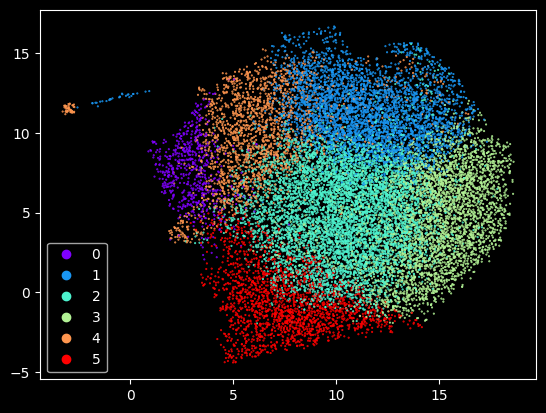

In [64]:
scatter_2d = plt.scatter(
    umap_embeddings_2d[:, 0],
    umap_embeddings_2d[:, 1],
    s=0.25,
    c=cluster_labels,
    cmap='rainbow',
)
plt.legend(*(scatter_2d.legend_elements()))
plt.show()

In [65]:
umap_embeddings_3d = umap.UMAP(
    n_neighbors=n_neighbors,
    n_components=3,
    min_dist=min_dist,
    metric='cosine',  # ignore magnitude of the document vectors
    random_state=SEED,
).fit_transform(vectorized_docs)

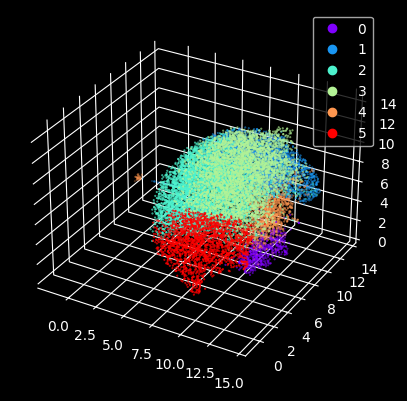

In [66]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter_3d = ax.scatter3D(
    umap_embeddings_3d[:, 0],
    umap_embeddings_3d[:, 1],
    umap_embeddings_3d[:, 2],
    s=0.25,
    c=cluster_labels,
    cmap='rainbow',
)
plt.legend(*(scatter_3d.legend_elements()))
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
plt.show()